In [1]:
from IPython.display import HTML
HTML('''<script>
var code_show_err = false; 
var code_toggle_err = function() {
 var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
 var stderr = Array.from(stderrNodes)
 if (code_show_err){
     stderr.forEach(ele => ele.style.display = 'block');
 } else {
     stderr.forEach(ele => ele.style.display = 'none');
 }
 code_show_err = !code_show_err
} 
document.addEventListener('DOMContentLoaded', code_toggle_err);
</script>
To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')

imports

In [59]:
#import several packaged that we will need
import sys
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from copy import deepcopy
from IPython import display
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
from scipy.optimize import curve_fit, fmin
from scipy.interpolate import interp1d
import scipy.constants as const
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import matplotlib.ticker as mtick
import warnings

#this is just needed to change the font size in the figures
SMALL_SIZE = 8#12
MEDIUM_SIZE = 8#14
BIGGER_SIZE = 10#16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

constants

In [60]:
#define several constants and conversion factors
Navo=const.Avogadro #6.022E23 #Avogadro number
au2m=5.29177E-11 #conversion from au of length to m
au2eV=27.2114 #conversion from au of energy to eV
e0=const.e # 1.602188E-19 #C (unit of charge)
au2J=au2eV*e0
kB=const.k #1.3806E-23 #J/K
eps0=const.epsilon_0 #8.854E-12 #F/m

conversions

In [61]:
#converts concentrations in M (mol/l) to SI units (partcles per cubic meter)
def M2SI(c0,**kwargs):
    return c0*Navo*1000

In [62]:
#converts concentrations in M (mol/l) to atomic units (particles per bohr^3)
def M2au(c0,**kwargs):
    c0SI=M2SI(c0,**kwargs)
    return c0SI*au2m**3

In [63]:
#converts concentrations in atomic units (particles per bohr^3) to M (mol/l)
def au2M(c0,**kwargs):
    return c0/au2m**3/Navo/1000

In [64]:
def SI2M(c0,**kwargs):
    return c0/Navo/1000

gamma

In [65]:
#define a function gamma, which defines the space in which ions may reside. Will be used to define epsilon too (see later)
def gamma(x,xGamma,DeltaGamma,**kwargs):
    return 1./(np.exp((xGamma-x)/DeltaGamma)+1)

epsilon

In [66]:
#define the dielectric function that changes with distance from the electrode making use of the function gamma defined before
def epsilonGamma(x,epsilonLeft,epsilonRight,xEpsilon,DeltaEpsilon,**kwargs):
    return epsilonLeft+gamma(x,xEpsilon,DeltaEpsilon)*(epsilonRight-epsilonLeft)

In [67]:
def epsilonLinear(x,epsilonLeft,epsilonRight,xEpsilon,xEpsilon2,**kwargs):
    x2=deepcopy(x)
    x2=np.minimum(x2,xEpsilon2)
    x2=np.maximum(x2,xEpsilon)
    return (epsilonLeft-epsilonRight)*(xEpsilon2-x2)/(xEpsilon2-xEpsilon)+epsilonRight

charge on metal

$\rho=\frac{q}{A\sqrt{2\pi}\Delta}e^{-\frac{x^2}{2\Delta^2}}$

In [68]:
def rho(x,q,A,DeltaQ,**kwargs):
    return q/(A*np.sqrt(2*np.pi)*DeltaQ)*np.exp(-x**2/DeltaQ**2/2.)

ion-metal interactions Upot

In [69]:
def repulsive(x,ion,xRepulsiveAn, DeltaRepulsiveAn,xRepulsiveCat, DeltaRepulsiveCat,T,**kwargs):
    if ion=='an':
        xRepulsive=xRepulsiveAn
        DeltaRepulsive=DeltaRepulsiveAn
    elif ion=='cat':
        xRepulsive=xRepulsiveCat
        DeltaRepulsive=DeltaRepulsiveCat
    else:
        sys.exit('Unknown calctype')
        
    return kB*T/au2J*np.exp(-(x-xRepulsive)/DeltaRepulsive)

In [70]:
def repulsive2(x,ion,xRepulsiveAn, xRepulsive2An,ERepulsiveAn,xRepulsiveCat, xRepulsive2Cat,ERepulsiveCat,**kwargs):
    if ion=='an':
        xRepulsive=xRepulsiveAn
        xRepulsive2=xRepulsive2An
        ERepulsive=ERepulsiveAn
    elif ion=='cat':
        xRepulsive=xRepulsiveCat
        xRepulsive2=xRepulsive2Cat
        ERepulsive=ERepulsiveCat
    else:
        sys.exit('Unknown calctype')
    x2=deepcopy(x)
    x2=np.minimum(x2,xRepulsive2)
    x2=np.maximum(x2,xRepulsive)
    kwargs['xRepulsive']=xRepulsive
    return ERepulsive/au2eV*(xRepulsive2-x2)/(xRepulsive2-xRepulsive)+repulsive(x,**kwargs)

In [71]:
def attractive(x,ion,EAttractiveAn, xAttractiveAn, DeltaAttractiveAn,EAttractiveCat, xAttractiveCat, DeltaAttractiveCat,**kwargs):
    if ion=='an':
        xAttractive=xAttractiveAn
        DeltaAttractive=DeltaAttractiveAn
        EAttractive=EAttractiveAn
    elif ion=='cat':
        xAttractive=xAttractiveCat
        DeltaAttractive=DeltaAttractiveCat
        EAttractive=EAttractiveCat
    else:
        sys.exit('Unknown calctype')
    return EAttractive/au2eV*((1-np.exp(-(x-xAttractive)/DeltaAttractive))**2-1)

In [72]:
def attractiveOnly(x,ion,EAttractiveAn, xAttractiveAn, DeltaAttractiveAn,EAttractiveCat, xAttractiveCat, DeltaAttractiveCat,**kwargs):
    if ion=='an':
        xAttractive=xAttractiveAn
        DeltaAttractive=DeltaAttractiveAn
        EAttractive=EAttractiveAn
    elif ion=='cat':
        xAttractive=xAttractiveCat
        DeltaAttractive=DeltaAttractiveCat
        EAttractive=EAttractiveCat
    else:
        sys.exit('Unknown calctype')
    return -EAttractive/au2eV*gamma(-x,-xAttractive,DeltaAttractive)

In [73]:
def attractive2(x,ion,**kwargs):
    return attractiveOnly(x,ion,**kwargs)+repulsive(x,ion,**kwargs)

In [74]:
def zero(x,ion,**kwargs):
    return 0*np.array(x)

ion concentration as function of phi

In [75]:
def conc(x,ion,Phi,z,otherz,thisc0, otherc0,cmax,T,Upot,**kwargs):
    kwargs['T']=T
    kbT=kB*T/au2J
    return gamma(x,**kwargs)*M2au(thisc0,**kwargs)*np.exp(-z*Phi/kbT-Upot(x,ion,**kwargs)/kbT)/(1-1./M2au(cmax,**kwargs)*(M2au(thisc0,**kwargs)*(1-np.exp(-z*Phi/kbT-Upot(x,ion,**kwargs)/kbT))+M2au(otherc0,**kwargs)*(1-np.exp(-otherz*Phi/kbT-Upot(x,ion,**kwargs)/kbT))))
    #return -z*0.5*q/(A*np.sqrt(2*np.pi)*DeltaQ)*np.exp(-(x-xGamma)**2/DeltaQ**2/2.)    

GC and Helmholz related computes

In [76]:
def get_lambdaDebeye(eps,T,c0An,c0Cat,zan,zcat,**kwargs):
    return np.sqrt(eps*eps0*kB*T/(M2SI(c0An,**kwargs)*zan**2*e0**2+M2SI(c0Cat,**kwargs)*zcat**2*e0**2))/au2m

In [77]:
def get_chargeGC(PhiSI,eps,T,c0An,c0Cat,zan,zcat,A,**kwargs):
    #return np.sqrt(8*kB*T*M2SI(c0,**kwargs)*eps*eps0)*np.sinh(e0*PhiSI/2./kB*T)/e0*A*au2m**2
    return np.sign(PhiSI)*np.sqrt(2*kB*T*eps*eps0)*np.sqrt(M2SI(c0An,**kwargs)*(np.exp(-zan*e0*PhiSI/(kB*T))-1)+M2SI(c0Cat,**kwargs)*(np.exp(-zcat*e0*PhiSI/(kB*T))-1))/e0*A*au2m**2

In [78]:
def get_chargeH(PhiSI,eps,A,xEpsilon,xEpsilon2,**kwargs):
    if xEpsilon2<0:
        d=xEpsilon
    else:
        d=xEpsilon2/10
    return PhiSI*eps*eps0*A*au2m**2/(d*au2m)/e0

In [79]:
def get_linGCcapacitance(eps,**kwargs):
    lambdaDebeye=get_lambdaDebeye(eps,**kwargs)
    kappa=1./(lambdaDebeye*au2m)
    return eps*eps0*kappa*1E2 #returns capacitance in muF/cm2

In [80]:
def get_nonlinGCcapacitance(eps,phi,T,**kwargs):
    kwargs['T']=T
    if not -kwargs['zan']==kwargs['zcat']:
        sys.error("GC capacitance so far only implemented for zan=-zcat")
    lambdaDebeye=get_lambdaDebeye(eps,**kwargs)
    kappa=1./(lambdaDebeye*au2m)
    return eps*eps0*kappa*np.cosh(kwargs['zan']*e0*phi/(2*kB*T))*1E2

In [81]:
def CGC(c0, phi1):
    return const.epsilon_0*eps_r/lambdaD(c0)*np.cosh(const.e*phi1/(2*const.k*T))

In [82]:
def get_lambdaFromGC(CGC,eps,**kwargs):
    return eps*eps0*1E2/(CGC*au2m)

In [83]:
def get_c0From1OverLinGC(OneOverCGC):
    eps=80
    T=300
    return SI2M((1./OneOverCGC/eps/eps0/1E2)**2*eps*eps0*kB*T/2/e0**2)

simplified relations at 300K assuminv |z|=1, not using the entire dict structure and assuming constant Helmholtz capacitance

In [84]:
#get the deltax=(xAttractive_xRepulsive) corresponding to a fit value a (using a square well assumption)
def a2delx(a):
    T=300
    return a/M2SI(1)/2/e0**2*kB*T/1E6/1E-4/au2m

In [85]:
#returns C_attractive in muF/cm^2
def getC_att(delx, b, c0, EAttractiveCat, EAttractiveAn, U1):
    T=300
    return M2SI(c0)*e0**2/kB/T*delx*au2m*1E-4*(np.exp(-e0*U1/kB/T)*(np.exp(e0*b*EAttractiveCat/kB/T)-1)+np.exp(e0*U1/kB/T)*(np.exp(e0*b*EAttractiveAn/kB/T)-1))*1E6
#myc0*a/2*np.exp((b*kwargs['EAttractiveCat']/au2eV*au2J)/(kwargs['T']*kB))*(np.exp(-e0*kwargs['zcat']*U1i/(kwargs['T']*kB)))
#myc0*a/2*(np.exp((b*kwargs['EAttractiveCat']/au2eV*au2J)/(kwargs['T']*kB))*(np.exp(-e0*kwargs['zcat']*U1i/(kwargs['T']*kB)))+np.exp((b*kwargs['EAttractiveAn']/au2eV*au2J)/(kwargs['T']*kB))*(np.exp(-e0*kwargs['zan']*U1i/(kwargs['T']*kB))))

In [86]:
#returns the coefficients of the polynomial defining the minimum in the capacitance
def polyMinCap(delx, b, c0, EAttractiveCat, EAttractiveAn):
    T=300
    lambdaDebeye=np.sqrt(80*eps0*kB*T/(M2SI(c0)*e0**2+M2SI(c0)*e0**2))/au2m
    kappa=1./(lambdaDebeye*au2m)
    p0=-M2SI(c0)*e0**2/kB/T*delx*au2m*(np.exp(b*e0*EAttractiveCat/kB/T)-1)
    p1=-80*eps0*kappa/4
    p2=0
    p3=80*eps0*kappa/4
    p4=M2SI(c0)*e0**2/kB/T*delx*au2m*(np.exp(b*e0*EAttractiveAn/kB/T)-1)
    plist=np.array([p4,p3,p2,p1,p0])
    return plist
    
#get the location of minimum in capacitance and the corresponding capacitance value and the expected GC capacitance(assumes constant Helmboltz capacitance C0)
def getMinCap(delx, b, c0, EAttractiveCat, EAttractiveAn, C0):
    T=300
    plist=polyMinCap(delx, b, c0, EAttractiveCat, EAttractiveAn)
    if plist[0]==0:
        soln=cardan(plist[1],plist[2],plist[3],plist[4])
        soln=np.array(soln)
    else:
        soln=ferrari(plist[0],plist[1],plist[2],plist[3],plist[4])
    #print(soln)
    #print(np.roots([plist[4], plist[3], plist[2], plist[1], plist[0]]))
    res=getPositiveRealSol(soln)
    #print(res)
    U1_min=np.log(res)/e0*2*kB*T
    #print(U1_min)
    C_att=getC_att(delx, b, c0, EAttractiveCat, EAttractiveAn, U1_min)
    C_GC_atMin=get_nonlinGCcapacitance(80,U1_min, c0An=c0, c0Cat=c0, T=T, zan=1, zcat=-1)
    C_GC_exp=get_nonlinGCcapacitance(80,0, c0An=c0, c0Cat=c0, T=T, zan=1, zcat=-1)
    C=1/(1/(C_att+C_GC_atMin)+1/C0)
    #print(U1_min,C_att,C_GC_atMin,C)
    return U1_min, C, C_GC_exp

In [87]:
# WARNING; THIS FUNCITON WAS NEVER USED OR TESTED!!!!
def get1OverMinCapForFitting(OneOverCGC, delx, c0, EAttractiveCat, EAttractiveAn, C0):
    T=300
    b=1
    c0=get_c0From1OverLinGC(OneOverCGC)
    plist=polyMinCap(delx, b, c0, EAttractiveCat, EAttractiveAn)
    if plist[0]==0:
        soln=cardan(plist[1],plist[2],plist[3],plist[4])
        soln=np.array(soln)
    else:
        soln=ferrari(plist[0],plist[1],plist[2],plist[3],plist[4])
    #print(soln)
    #print(np.roots([plist[4], plist[3], plist[2], plist[1], plist[0]]))
    res=getPositiveRealSol(soln)
    #print(res)
    U1_min=np.log(res)/e0*2*kB*T
    #print(U1_min)
    C_att=getC_att(delx, b, c0, EAttractiveCat, EAttractiveAn, U1_min)
    C_GC_atMin=get_nonlinGCcapacitance(80,U1_min, c0An=c0, c0Cat=c0, T=T, zan=1, zcat=-1)
    C_GC_exp=get_nonlinGCcapacitance(80,0, c0An=c0, c0Cat=c0, T=T, zan=1, zcat=-1)
    C=1/(1/(C_att+C_GC_atMin)+1/C0)
    #print(U1_min,C_att,C_GC_atMin,C)
    return 1./C

In [88]:
#get Utot from U1 assuming constant C0
def getUtot(delx, b, c0, EAttractiveCat, EAttractiveAn, C0,U1, returnC=False):
    T=300
    #compute capacitances
    C_att=getC_att(delx, b, c0, EAttractiveCat, EAttractiveAn, U1)
    C_GC=get_nonlinGCcapacitance(80,U1, c0An=c0, c0Cat=c0, T=T, zan=1, zcat=-1)
    #compute charges
    qPerCm2=-e0*M2SI(c0)*delx*au2m*((np.exp(b*EAttractiveCat*e0/kB/T)-1)*np.exp(-e0*U1/kB/T)-(np.exp(b*EAttractiveAn*e0/kB/T)-1)*np.exp(e0*U1/kB/T))*1E-4
    A=1 #in au^2
    qGCPerCm2=get_chargeGC(U1,80,T,c0,c0,-1,1,A=1)/A/au2m**2*e0*1E-4
    #compute potential drop over Helmholz region
    deltaU=(qGCPerCm2+qPerCm2)/(C0*1E-6)
    #add up potential drops
    Utot=U1+deltaU
    if returnC:
        C=1/(1/(C_att+C_GC)+1/C0)
        return Utot, C, qPerCm2
    else:
        return Utot

In [89]:
def getCapacity_analytical(delx, b, c0, EAttractiveCat, EAttractiveAn, C0, delU1=2E-2, U1start=0, UtotMin=-0.4, UtotMax=0.4):
    T=300
    qV=[]
    UCdiff=[]
    Utot, C, qPerCm2 =getUtot(delx, b, c0, EAttractiveCat, EAttractiveAn, C0,U1start, returnC=True)
    qV.append([qPerCm2,Utot])
    UCdiff.append([Utot,C]) #uF/cm2
    U1=U1start
    #print(Utot)
    while Utot>UtotMin: 
        U1=U1-delU1
        #print('decrease', Utot)
        Utot, C, qPerCm2 =getUtot(delx, b, c0, EAttractiveCat, EAttractiveAn, C0,U1, returnC=True)
        qV.append([qPerCm2,Utot])
        UCdiff.append([Utot,C]) #uF/cm2
    Utot, C, qPerCm2 =getUtot(delx, b, c0, EAttractiveCat, EAttractiveAn, C0,U1start, returnC=True)
    U1=U1start
    while Utot<UtotMax:
        U1=U1+delU1
        #print('increase', Utot)
        Utot, C, qPerCm2 =getUtot(delx, b, c0, EAttractiveCat, EAttractiveAn, C0,U1, returnC=True)
        qV.append([qPerCm2,Utot])
        UCdiff.append([Utot,C]) #uF/cm2
    qV=np.array(qV)
    UCdiff=np.array(UCdiff)
    return qV,UCdiff #NOTE: may be in different units than in getCapacity!!!!

diff equation and boundary conditions

In [90]:
def diffeq(x,var,zcat,zan,c0Cat, c0An,UpotCat, UpotAn,epsilon,**kwargs):
    kwargs['epsilon']=epsilon
    [Phi, epsdPhi]=var
    
    dPhi_dx=epsdPhi/epsilon(x,**kwargs)
    dEpsdPhi_dx=-4*np.pi*(rho(x,**kwargs)
                         +zcat*conc(x,'cat',Phi,zcat,zan,c0Cat, c0An,Upot=UpotCat,**kwargs)
                         + zan*conc(x,'an',Phi,zan,zcat,c0An, c0Cat,Upot=UpotAn,**kwargs))
    return[dPhi_dx, dEpsdPhi_dx]

In [91]:
def boundary(vara, varb):
    [Phia, epsdPhia]=vara
    [Phib, epsdPhib]=varb
    return np.array([epsdPhia, Phib]) #Phi=0 on right hand side, phi'+0 on left hand side --> epsion*Phi'=0 

In [92]:
def solve_laplaceEq(epsilon,tol=None,max_nodes=None,**kwargs):
    kwargs['epsilon']=epsilon
    #estimate grid size
    maxeps=epsilon(1000,**kwargs)
    lambdaDebeye=get_lambdaDebeye(maxeps,**kwargs)
    #solve diffEq., increase grid size until boundary contiditions are met
    dPhi=100
    maxx=10*lambdaDebeye
    if tol==None:
        tol=0.00001
    if max_nodes==None:
        max_nodes=100000
    while abs(dPhi)>1E-8:
        xs=np.append(np.arange(-10,20,0.001),np.arange(20,maxx,maxx/500))#np.arange(-10,maxx,0.01)
        ys=np.array([[0]*len(xs),[0]*len(xs)] )
        var=solve_bvp(fun=lambda x,y: diffeq(x,y,**kwargs), bc=boundary, x=xs, y=ys, tol=tol, max_nodes=max_nodes)
        dPhi=var.yp[0,-1]
        maxx+=2*lambdaDebeye
    return var

routines (e.g., getCapacity as function of V, getCdiffvsCGC as function of c0, plotForChangeDicts: plot 1/Cdiff vs 1/CGS for several change dicts)

In [93]:
def getCapacity(calctype,show,T,zan,zcat,UpotAn,UpotCat,c0An,c0Cat,A,xGamma,epsilon,rangeMult=None,nMult=1,startq=None, stopq=None, tol=None, max_nodes=None, **kwargs):
    #calctype can be 'curve' (returns a capacitance curve for -0.2V/pzc:0.2V/pzc) or 'pzc' (returns a capacitance near pzc)
    kwargs['T']=T
    kwargs['zan']=zan
    kwargs['zcat']=zcat
    kwargs['UpotAn']=UpotAn
    kwargs['UpotCat']=UpotCat
    kwargs['c0An']=c0An
    kwargs['c0Cat']=c0Cat
    kwargs['A']=A
    kwargs['xGamma']=xGamma
    kwargs['epsilon']=epsilon
    #estimate charge
    if calctype=='curve':
        Phi0max=0.6 #V
    elif calctype=='pzc':
        Phi0max=0.005 #V
    else:
        sys.exit('Unknown calctype')
    maxeps=epsilon(1000,**kwargs)
    mineps=epsilon(0,**kwargs)
    qmaxGC=get_chargeGC(Phi0max,maxeps,**kwargs)
    qmaxH=get_chargeH(Phi0max,mineps,**kwargs)
    qmax=min(qmaxGC,qmaxH)
    if not rangeMult==None:
        qmax=qmax*rangeMult
    if calctype=='curve':
        if startq==None:
            qlist=np.linspace(-qmax,qmax,int(60*nMult))
        else:
            qlist=np.linspace(startq,stopq,int(60*nMult))
    else:
        qlist=[-qmax,qmax]
    #cycle through all q in qlist
    qV=[]
    #plt.ion()
    if show>=0:
        fig,ax=pl.subplots(1,3, figsize=(12,3))
    for q in qlist:
        kwargs['q']=q
        var=solve_laplaceEq(tol=tol, max_nodes=max_nodes, **kwargs)
        if var.status==0:
            V=(var.y[0,0]-var.y[0,-1])*au2eV
            #if calctype=='pzc', only accept value if 0.002<V<0.01. Otherwise estimate new q and cycle
            #print("V={}: q={}".format(V,q))
            if calctype=='pzc' and (V*np.sign(q)<0.002 or V*np.sign(q)>0.01):
                qnew=q*Phi0max/V*np.sign(V)
                #qnew=(q+qnew)*0.5
                #print("V={}; Old q={}, new q={}".format(V,q,qnew))
                qlist.append(qnew)
                continue
            qV.append([q,V])
            #qV.append([-q,-V])
            #print(q,V)
            if show>=0:
                #pl.plot(var.x,var.y[0,:]*27.211, label='numerical');
                #pl.xlabel('x [au]')
                #pl.ylabel('U [V/pzc]')
                #display.clear_output(wait=True)
                #display.display(pl.gcf())
                ax[0].plot(var.x,var.y[0,:]*27.211, label='numerical');
                ax[0].set_xlabel("x [au]")
                ax[0].set_ylabel("U [V/pzc]")
                #ax[1].plot(var.x,au2M(conc(var.x,var.y[0,:],zan,zcat,**kwargs)))
                ax[1].plot(var.x,au2M(conc(var.x,'an',var.y[0,:],zan,zcat,c0An, c0Cat,Upot=UpotAn,**kwargs)))
                ax[1].set_xlim(var.x[0], max(40,var.x[-1]/6))
                ax[1].set_xlabel("x [au]")
                ax[1].set_ylabel("c_Anion [M]")
                ax[2].plot(var.x,au2M(conc(var.x,'cat',var.y[0,:],zcat,zan,c0Cat, c0An,Upot=UpotCat,**kwargs)))
                ax[2].set_xlim(var.x[0], max(40,var.x[-1]/6))
                ax[2].set_xlabel("x [au]")
                ax[2].set_ylabel("c_Cation [M]")
                pl.tight_layout()
                display.clear_output(wait=True)
                display.display(pl.gcf())
        else:
            print("not converged")
    if show>=0:
        plt.close()
    #sort qV array
    qV=np.array(qV)
    qV.sort(0)
    #compute differential capacitance
    UCdiff=[]
    for i in range(len(qV[:,0])-1):
        U=0.5*(qV[i,1]+qV[i+1,1])
        Cdiff=((qV[i+1,0]-qV[i,0])*e0/(A*au2m**2))/(qV[i+1,1]-qV[i,1])
        UCdiff.append([U,Cdiff*1E6*1E-4]) #uF/cm2
    UCdiff=np.array(UCdiff)
    #plot results
    if (show>=1):
        fig,ax=pl.subplots(1,2, figsize=(8,3))
        ax[0].plot(qV[:,1], qV[:,0],'x')
        ax[0].set_xlabel('U [V/pzc]')
        ax[0].set_ylabel('q/A [e0]')
    
        ax[1].plot(UCdiff[:,0], UCdiff[:,1], 'x')
        ax[1].set_xlabel('U [V/pzc]')
        ax[1].set_ylabel('diff. capacitance \n[uF/cm2]')
        plt.tight_layout()
    return qV,UCdiff

In [94]:
def get_Cdiff_vs_CGC(**kwargs):
    if 'c0An' in kwargs:
        print("WARNING: c0An and c0Cat in kwargs will be overwritten!")
    c0list=[0.001,0.002,0.003, 0.005,0.01,0.02,0.03,0.05,0.1,0.5,1]
    #c0list=[0.001,0.003,0.007,0.026] #for Au
    #c0list=[0.0001,0.0002, 0.0004,0.0006, 0.0011, 0.0031, 0.01,0.1,0.5,1]
    #c0list=[0.0001,0.0002, 0.0004,0.0006, 0.0011, 0.0031, 0.01,0.1]
    #c0list=[0.00005, 0.0001,0.0003, 0.0005,0.001,0.002,0.003, 0.005,0.01,0.02,0.03,0.05,0.1,0.5,1]
    Cdiff=[]
    CGC=[]
    for c0 in c0list:
        kwargs['c0An']=c0
        kwargs['c0Cat']=c0
        qV,UCdiff=getCapacity(calctype='pzc',show=-1,**kwargs)
        Cdiff.append(UCdiff[0,1])
        CGC.append(get_linGCcapacitance(80,**kwargs))
    return np.array([c0list,CGC,Cdiff]).transpose()
        

In [95]:
def twinaxis_lambdaDebeye(ax1,**kwargs):
    #ax1 = fig.gca()
    ax2 = ax1.twiny()
    ax1Xs = ax1.get_xticks()
    ax2Xs=get_lambdaFromGC(1/ax1Xs,80)
    ax2.set_xticks(ax1Xs)
    ax2.set_xbound(ax1.get_xbound())
    ax2.set_xticklabels(["{:.0f}".format(x) for x in ax2Xs]);
    ax2.set_xlabel(r"$\lambda_D [au]$")
    

In [96]:
def plotForChangeDicts(changeDicts,**kwargs0):
    results=[]
    for changeDict in changeDicts:
        kwargs=deepcopy(kwargs0)
        del kwargs['c0An']
        del kwargs['c0Cat']
        for key in changeDict:
            kwargs[key]=changeDict[key]
        res=get_Cdiff_vs_CGC(**kwargs)
        kwargs['res']=res
        kwargs['changeDict']=changeDict
        results.append(kwargs)
    fig=plt.figure()
    for result in results:
        res=result['res']
        plt.plot(1/res[:,1], 1/res[:,2], 'x-', label=str(result['changeDict']))
    plt.xlabel("1/C_GC [cm2/uF]")
    plt.ylabel("1/C [cm2/uF]")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    twinaxis_lambdaDebeye(fig,**kwargs)
    fig=plt.figure()
    for result in results:
        res=result['res']
        plt.plot(1/res[-4:-1,1], 1/res[-4:-1,2], 'x-', label=str(result['changeDict']))
    plt.xlabel("1/C_GC [cm2/uF]")
    plt.ylabel("1/C [cm2/uF]")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(0)
    twinaxis_lambdaDebeye(fig,**kwargs)
    return results

In [97]:
def plotCC_forChangeDicts(changeDicts,show=1,axret=False,**kwargs0):
    results=[]
    for changeDict in changeDicts:
        #print(changeDict)
        kwargs=deepcopy(kwargs0)
        c0AnOrig=kwargs['c0An']
        c0CatOrig=kwargs['c0Cat']
        if not c0AnOrig==c0AnOrig:
            sys.exit("Function onlz written for 1:1 electrolytes so far")
        del kwargs['c0An']
        del kwargs['c0Cat']
        for key in changeDict:
            kwargs[key]=changeDict[key]
        res=get_Cdiff_vs_CGC(**kwargs)
        kwargs['res']=res
        kwargs['changeDict']=changeDict
        results.append(kwargs)
    if show==1:
        fig,ax=plt.subplots(1,2,figsize=(15,4))
        for result in results:
            res=result['res']
            ax[0].plot(1/res[:,1], 1/res[:,2], 'x-', label=str(result['changeDict']))
        ax[0].set_xlabel("1/C_GC [cm2/uF]")
        ax[0].set_ylabel("1/C [cm2/uF]")
        #ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        twinaxis_lambdaDebeye(ax[0],**kwargs)
        for result in results:
            res=result['res']
            ax[1].plot(1/res[-7:-1,1], 1/res[-7:-1,2], 'x-', label=str(result['changeDict']))
        ax[1].set_xlabel("1/C_GC [cm2/uF]")
        ax[1].set_ylabel("1/C [cm2/uF]")
        #ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax[1].set_xlim(0)
        twinaxis_lambdaDebeye(ax[1],**kwargs)
    if not show:
        ax=0
    if not axret:
        return results
    else:
        return results,ax

In [98]:
def fitfun(c0, alpha,CH, **kwargs):
    if 'c0An' in kwargs:
        print("WARNING: c0 in kwargs will be overwritten!")
    kwargs['c0An']=c0
    kwargs['c0Cat']=c0
    CGC=get_linGCcapacitance(80,**kwargs)
    del kwargs['c0An']
    del kwargs['c0Cat']
    return 1./(CGC+alpha*c0)+1./CH
    #return 1./(alpha*c0+beta*CGC)+1./CH
    #return 1./CGC + 1/(alpha*c0) #does not work!!!!

In [99]:
def fitfun2(EAttractive,a,b):
    return a*(np.exp(EAttractive)-1)

In [100]:
def fit_results_C0_EAtt(changeDicts, show=True,**mykwargs):
    results,ax=plotCC_forChangeDicts(changeDicts,show=show, axret=True, **mykwargs)
    #line_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']*2
    line_colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    EAttractive=[]
    for j,result in enumerate(results):
        res=result['res']
        EAttractive.append(result['EAttractiveAn'])
        fitfunEAttractive=lambda c0,alpha,CH,**kwargs: fitfun(c0,alpha,CH,**result)
        popt, pcov = curve_fit(fitfunEAttractive, res[:,0], 1./res[:,2],p0=[1E4,100]) #p0=[1E4,1,10])
        result['popt']=popt
        #plt.plot(1/get_linGCcapacitance(80,c0=res[:,0],**result), 1./res[:,2], 'x',color=line_colors[j], label=str(result['changeDict']))
        if show:
            ax[0].plot(1/get_linGCcapacitance(80,c0An=res[:,0],c0Cat=res[:,0],**result), fitfunEAttractive(res[:,0], *result['popt'],**result),marker='o',markersize=8,  mfc='none', color=line_colors[j])
            xmin,xmax=ax[0].get_xlim();
            ax[0].text(xmax,fitfunEAttractive(res[0,0], *result['popt'],**result),r'$\alpha={:1.1e}, C_H={:.0f}$'.format(popt[0],popt[1]) , color=line_colors[j])
            ax[1].plot(1/get_linGCcapacitance(80,c0An=res[-7:-1,0],c0Cat=res[-7:-1,0],**result), fitfunEAttractive(res[-7:-1,0], *result['popt'],**result),marker='o',markersize=8,  mfc='none',color=line_colors[j])
    if show:
        box = ax[1].get_position()
        box.x0 = box.x0 + 0.15
        box.x1 = box.x1 + 0.15
        ax[1].set_position(box)
        ax[1].set_xlim(0)
    
    if show:
        plt.figure(figsize=(3.5,2.5))
        #plt.figure();
    Elist=[result['EAttractiveAn']/(au2eV*kB*result['T']/au2J) for result in results[1:]]
    alphalist=[result['popt'][0] for result in results[1:]]
    [a,b], pcov = curve_fit(fitfun2,Elist,alphalist)
    if show:
        plt.plot(Elist,alphalist,'x')
        plt.plot(Elist, fitfun2(np.array(Elist),a,b))
        plt.xlabel(r'$\frac{ U}{k_B\cdot T}$', fontsize=18)
        plt.ylabel(r'$\alpha$', fontsize=18)
        plt.yscale('log')
        plt.text(Elist[-1]+1, alphalist[-1],r'$C_{{ads}}={:2.2f}\cdot c_0\cdot \left(e^{{\frac{{U}}{{k_B\cdot T}}}}-1\right)$'.format(a), fontsize=24);
    return results,a,b

Helper functions

In [101]:
#solving for the roots of a 4th order polynomial using the ferrari method
#from
#https://stackoverflow.com/questions/35795663/fastest-way-to-find-the-smallest-positive-real-root-of-quartic-polynomial-4-degr
def ferrari(a,b,c,d,e):
    "resolution of P=ax^4+bx^3+cx^2+dx+e=0"
    "CN all coeffs real."
    "First shift : x= z-b/4/a  =>  P=z^4+pz^2+qz+r"
    z0=b/4/a
    a2,b2,c2,d2 = a*a,b*b,c*c,d*d 
    p = -3*b2/(8*a2)+c/a
    q = b*b2/8/a/a2 - 1/2*b*c/a2 + d/a
    r = -3/256*b2*b2/a2/a2 +c*b2/a2/a/16-b*d/a2/4+e/a
    "Second find X so P2=AX^3+BX^2+C^X+D=0"
    A=8
    B=-4*p
    C=-8*r
    D=4*r*p-q*q
    y0,y1,y2=cardan(A,B,C,D)
    if abs(y1.imag)<abs(y0.imag): y0=y1 
    if abs(y2.imag)<abs(y0.imag): y0=y2 
    a0=(-p+2*y0.real)**.5
    if a0==0 : b0=y0**2-r
    else : b0=-q/2/a0
    r0,r1=roots2(1,a0,y0+b0)
    r2,r3=roots2(1,-a0,y0-b0)
    return (r0-z0,r1-z0,r2-z0,r3-z0) 
J=np.exp(2j*np.pi/3)
Jc=1/J
def cardan(a,b,c,d):
    u=np.empty(2,np.complex128)
    z0=b/3/a
    a2,b2 = a*a,b*b    
    p=-b2/3/a2 +c/a
    q=(b/27*(2*b2/a2-9*c/a)+d)/a
    D=-4*p*p*p-27*q*q
    r=np.sqrt(-D/27+0j)        
    u=((-q-r)/2)**0.33333333333333333333333
    v=((-q+r)/2)**0.33333333333333333333333
    w=u*v
    w0=abs(w+p/3)
    w1=abs(w*J+p/3)
    w2=abs(w*Jc+p/3)
    if w0<w1: 
        if w2<w0 : v*=Jc
    elif w2<w1 : v*=Jc
    else: v*=J        
    return u+v-z0, u*J+v*Jc-z0,u*Jc+v*J-z0
def roots2(a,b,c):
    bp=b/2    
    delta=bp*bp-a*c
    u1=(-bp-delta**.5)/a
    u2=-u1-b/a
    return u1,u2  

#get positive real solution from ferrari or cardan
def getPositiveRealSol(soln):
    soln=np.array(soln)
    res=soln[(abs(soln.imag)<1E-10) & (soln.real>=0) ].real
    if not len(res)==1:
        if len(res)==0:
            sys.exit("getPositiveRealsSoln could not find a valid solution: {}".format(soln))
            return zero
        if len(res)>1:
            #sys.warning("getPositiveRealsSoln found more than one valid solution: {}".format(soln))
            imin=np.argmin(abs(res-1))
            return res[imin]
    else:
        return res[0]

In [102]:
def linfun(x,a,b):
    return a*x+b

Functions for water adsorption from Jiabo Le's paper

In [103]:
waterAds0={}
waterAds0['p']=0.26*const.e*const.angstrom
waterAds0['l_A']=1.7*const.angstrom
waterAds0['l_H']=1.8*const.angstrom
waterAds0['eps_s']=4
waterAds0['eps_r']=80
waterAds0['theta_max']=0.51
waterAds0['areaPerPt']=2.772**2*np.sqrt(3)/2*const.angstrom**2
waterAds0['Nsite']=1/waterAds0['areaPerPt']
waterAds0['T']=300
waterAds0['theta_sigma0']=0.2
#waterAds0['sigma0']=-const.k*waterAds['T']*waterAds['eps_s']*const.epsilon_0/waterAds['p']*np.log(waterAds['theta_sigma0']/(waterAds['theta_max']-waterAds['theta_sigma0']))-waterAds['p']*waterAds['theta_sigma0']*waterAds['Nsite']*waterAds['eps_s']/waterAds['l_A']
#waterAds0['phi0']=waterAds['p']*waterAds['theta_sigma0']*waterAds['Nsite']/const.epsilon_0

In [104]:
def get_sigma0(T, eps_s, p, theta_sigma0, theta_max, Nsite, l_A, **kwargs):
    return -const.k*T*eps_s*const.epsilon_0/p*np.log(theta_sigma0/(theta_max-theta_sigma0))-p*theta_sigma0*Nsite*eps_s/l_A

In [105]:
def get_phi0(p, Nsite, theta_sigma0, **kwargs):
    return p*theta_sigma0*Nsite/const.epsilon_0

In [106]:
kwargs0={
    #temperature
    'T':waterAds0['T'],
    #parameters for rho
    'q':0.5, #charge on metal surf
    'A':10**2, #area of metal surf
    'DeltaQ':0.02, #width of charge dist on metal surf
    #parameters for conc
    'c0An':0.01, #M
    'cmax':3, #M
    'c0Cat':0.01, #M
    'zcat':1, #charge of cations
    'zan':-1, #charge of anions
    #+parameters for gamma
    'xGamma':0.1, #au
    'DeltaGamma':0.03, #au
    #parameters for repulsive function
    'xRepulsiveAn':6.0, #au
    'DeltaRepulsiveAn':0.2, #au
    'xRepulsiveCat':6.0, #au
    'DeltaRepulsiveCat':0.2, #au
    #paramters for attractive function
    'EAttractiveAn':0.1, #eV
    'xAttractiveAn':8.0, #au
    'DeltaAttractiveAn':0.1, #au was 0.5
    'EAttractiveCat':0.1, #eV
    'xAttractiveCat':8.0, #au
    'DeltaAttractiveCat':0.1, #au was 0.5
    #parameters for dielectric function
    'epsilon':epsilonLinear,
    'epsilonLeft':waterAds0['eps_s'], #epsilon on left of xEpsilon function
    'epsilonRight':waterAds0['eps_r'], #epsilon on right of xEpsilon function
    'xEpsilon':waterAds0['l_H']/au2m, #au
    'xEpsilon2':(waterAds0['l_H']+0.5*const.angstrom)/au2m, #au should be negative epsilonGamma
    'DeltaEpsilon':0.03, #au
    #set ion function
    'UpotAn':repulsive,
    'UpotCat':repulsive
}

In [107]:
def sigma(thetaA, T, eps_s, p, theta_max, Nsite, l_A, sigmaVal=0, **kwargs):
    kwargs['T']=T
    kwargs['eps_s']=eps_s
    kwargs['p']=p
    kwargs['theta_max']=theta_max
    kwargs['Nsite']=Nsite
    kwargs['l_A']=l_A
    sigma0=get_sigma0(**kwargs)
    return const.k*T*eps_s*const.epsilon_0/p*np.log(thetaA/(theta_max-thetaA))+p*thetaA*Nsite*eps_s/l_A+sigma0-sigmaVal

In [108]:
def DeltaPhiWater(thetaA, sigmaVal, p, Nsite, **kwargs):
    kwargs['p']=p
    kwargs['Nsite']=Nsite
    phi0=get_phi0(**kwargs)
    return -p*thetaA*Nsite/const.epsilon_0 + phi0

In [109]:
def DeltaPhiHelmholtz(thetaA, sigmaVal, eps_s, l_H, **kwargs):
    return sigmaVal/(const.epsilon_0*eps_s)*l_H

In [110]:
def get_OneOverCWater(thetaA, p, Nsite, T, theta_max, eps_s, l_A, **kwargs):
    return -p*Nsite/const.epsilon_0*1/(const.k*T*eps_s*const.epsilon_0/p*theta_max/thetaA/(theta_max-thetaA)+p*Nsite*eps_s/l_A)

In [111]:
def DeltaPhi(thetaA, sigmaVal, p, Nsite, eps_s, l_H, **kwargs):
    kwargs['p']=p
    kwargs['Nsite']=Nsite
    phi0=get_phi0(**kwargs)
    return -p*thetaA*Nsite/const.epsilon_0+sigmaVal/(const.epsilon_0*eps_s)*l_H + phi0

# Results

## Results for paper

ion attraction (same ion size) and water adsorption (with modified parameters for water adsorption)

C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow e

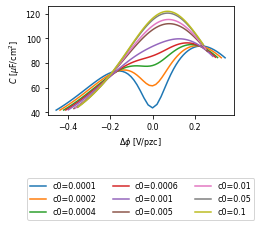

In [113]:
#c0list=[0.0001,0.0002, 0.0004,0.0006, 0.0011, 0.0021]
c0list=[0.0001, 0.0002, 0.0004,0.0006, 0.001, 0.005, 0.01, 0.05, 0.1]#,0.0004, 0.0021]
kwargs=deepcopy(kwargs0)
waterAds=deepcopy(waterAds0)
waterAds['l_A']=2.0*const.angstrom
kwargs['cmax']=40000
kwargs['xRepulsiveAn']=6
kwargs['xRepulsiveCat']=6
kwargs['xAttractiveAn']=10
kwargs['xAttractiveCat']=10
kwargs['UpotCat']=attractive2
kwargs['UpotAn']=attractive2
kwargs['EAttractiveAn']=0.22
kwargs['EAttractiveCat']=0.22

fig1=plt.figure(figsize=(3.33,2))
#fig1=plt.figure()
ax1=fig1.gca()
line_colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
nMult=1
for j,myc0 in enumerate(c0list):
    kwargs['c0An']=myc0
    kwargs['c0Cat']=myc0
    qVAt,UCdiffAt=getCapacity('curve',show=-1,rangeMult=0.3,nMult=nMult,tol=1E-7, **kwargs)#1.8
    
    sigma_list=qVAt[:,0]*const.e/(kwargs['A']*au2m**2)
    thetaA_list=[]
    DeltaPhiWater_list=[]
    OneOverCWater_list=[]
    CWaterNum_list=[]
    DeltaPhiWater_list_forCH=[]
    for sigmaVal in sigma_list:
        mysigma=lambda x: sigma(x, **waterAds, sigmaVal=sigmaVal)
        thetaA=fsolve(mysigma, 0.01)[0]
        thetaA_list.append(thetaA)
        DeltaPhiVal=DeltaPhiWater(thetaA, sigmaVal, **waterAds)
        DeltaPhiWater_list.append(DeltaPhiVal)
        OneOverCWater=get_OneOverCWater(thetaA, **waterAds)
        OneOverCWater_list.append(OneOverCWater)
    for i in range(0,len(sigma_list)-1):
        CWaterNum_list.append((sigma_list[i+1]-sigma_list[i])/(DeltaPhiWater_list[i+1]-DeltaPhiWater_list[i]))
        DeltaPhiWater_list_forCH.append((DeltaPhiWater_list[i+1]+DeltaPhiWater_list[i])/2)
    OneOverCWater_list=np.array(OneOverCWater_list)
    CWaterNum_list=np.array(CWaterNum_list)
    
    #plt.figure()
    #plt.plot(DeltaPhiWater_list, 1/OneOverCWater_list)
    #plt.plot(DeltaPhiWater_list_forCH, CWaterNum_list)
        
    #ax1.plot(UCdiffAt[:,0], UCdiffAt[:,1], label='c0={}'.format(myc0), color=line_colors[j])
    ax1.plot(UCdiffAt[:,0]+DeltaPhiWater_list_forCH, 1/(1/UCdiffAt[:,1]+1/CWaterNum_list*1E-2), color=line_colors[j], label='c0={}'.format(myc0))

ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0),ncol=3)
#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_xlabel("$\Delta \phi$ [V/pzc]")
ax1.set_ylabel("$C$ [$\mu$F/cm$^2$]")
#ax1.set_ylabel("diff. capacitance [uF/cm2]")
fig1.savefig('ionAtt_waterAds.svg', format='svg', dpi=300)

same as above but without model by Le

C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow e

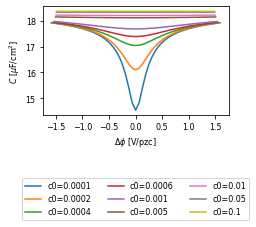

In [114]:
#c0list=[0.0001,0.0002, 0.0004,0.0006, 0.0011, 0.0021]
c0list=[0.0001, 0.0002, 0.0004,0.0006, 0.001, 0.005, 0.01, 0.05, 0.1]#,0.0004, 0.0021]
kwargs=deepcopy(kwargs0)
waterAds=deepcopy(waterAds0)
waterAds['l_A']=2.0*const.angstrom
kwargs['cmax']=40000
kwargs['xRepulsiveAn']=6
kwargs['xRepulsiveCat']=6
kwargs['xAttractiveAn']=10
kwargs['xAttractiveCat']=10
kwargs['UpotCat']=attractive2
kwargs['UpotAn']=attractive2
kwargs['EAttractiveAn']=0.22
kwargs['EAttractiveCat']=0.22

fig1=plt.figure(figsize=(3.33,2))
ax1=fig1.gca()
line_colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
nMult=1
for j,myc0 in enumerate(c0list):
    kwargs['c0An']=myc0
    kwargs['c0Cat']=myc0
    qVAt,UCdiffAt=getCapacity('curve',show=-1,rangeMult=0.3,nMult=nMult,tol=1E-7, **kwargs)#1.8
    
    sigma_list=qVAt[:,0]*const.e/(kwargs['A']*au2m**2)
    thetaA_list=[]
    DeltaPhiWater_list=[]
    OneOverCWater_list=[]
    CWaterNum_list=[]
    DeltaPhiWater_list_forCH=[]
    for sigmaVal in sigma_list:
        mysigma=lambda x: sigma(x, **waterAds, sigmaVal=sigmaVal)
        thetaA=fsolve(mysigma, 0.01)[0]
        thetaA_list.append(thetaA)
        DeltaPhiVal=DeltaPhiWater(thetaA, sigmaVal, **waterAds)
        DeltaPhiWater_list.append(DeltaPhiVal)
        OneOverCWater=get_OneOverCWater(thetaA, **waterAds)
        OneOverCWater_list.append(OneOverCWater)
    for i in range(0,len(sigma_list)-1):
        CWaterNum_list.append((sigma_list[i+1]-sigma_list[i])/(DeltaPhiWater_list[i+1]-DeltaPhiWater_list[i]))
        DeltaPhiWater_list_forCH.append((DeltaPhiWater_list[i+1]+DeltaPhiWater_list[i])/2)
    OneOverCWater_list=np.array(OneOverCWater_list)
    CWaterNum_list=np.array(CWaterNum_list)
    
    #plt.figure()
    #plt.plot(DeltaPhiWater_list, 1/OneOverCWater_list)
    #plt.plot(DeltaPhiWater_list_forCH, CWaterNum_list)
        
    #ax1.plot(UCdiffAt[:,0], UCdiffAt[:,1], label='c0={}'.format(myc0), color=line_colors[j])
    ax1.plot(UCdiffAt[:,0], UCdiffAt[:,1], color=line_colors[j], label='c0={}'.format(myc0))
    
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0),ncol=3)
#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_xlabel("$\Delta \phi$ [V/pzc]")
ax1.set_ylabel("$C$ [$\mu$F/cm$^2$]")
fig1.savefig('ionAtt.svg', format='svg', dpi=300)

same as above, but for EAttractive=0

C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


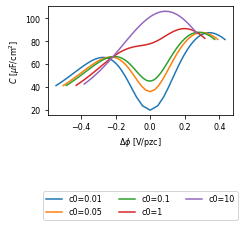

In [115]:
#c0list=[0.0001,0.0002, 0.0004,0.0006, 0.0011, 0.0021]
c0list=[0.01, 0.05, 0.1,1,10]#,0.0004, 0.0021]
kwargs=deepcopy(kwargs0)
waterAds=deepcopy(waterAds0)
waterAds['l_A']=2.0*const.angstrom
kwargs['cmax']=40000
kwargs['xRepulsiveAn']=6
kwargs['xRepulsiveCat']=6
kwargs['xAttractiveAn']=10
kwargs['xAttractiveCat']=10
kwargs['UpotCat']=attractive2
kwargs['UpotAn']=attractive2
kwargs['EAttractiveAn']=0.0
kwargs['EAttractiveCat']=0.0

fig1=plt.figure(figsize=(3.33,2))
ax1=fig1.gca()
line_colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
nMult=1
for j,myc0 in enumerate(c0list):
    kwargs['c0An']=myc0
    kwargs['c0Cat']=myc0
    qVAt,UCdiffAt=getCapacity('curve',show=-1,rangeMult=0.3,nMult=nMult,tol=1E-7, **kwargs)#1.8
    
    sigma_list=qVAt[:,0]*const.e/(kwargs['A']*au2m**2)
    thetaA_list=[]
    DeltaPhiWater_list=[]
    OneOverCWater_list=[]
    CWaterNum_list=[]
    DeltaPhiWater_list_forCH=[]
    for sigmaVal in sigma_list:
        mysigma=lambda x: sigma(x, **waterAds, sigmaVal=sigmaVal)
        thetaA=fsolve(mysigma, 0.01)[0]
        thetaA_list.append(thetaA)
        DeltaPhiVal=DeltaPhiWater(thetaA, sigmaVal, **waterAds)
        DeltaPhiWater_list.append(DeltaPhiVal)
        OneOverCWater=get_OneOverCWater(thetaA, **waterAds)
        OneOverCWater_list.append(OneOverCWater)
    for i in range(0,len(sigma_list)-1):
        CWaterNum_list.append((sigma_list[i+1]-sigma_list[i])/(DeltaPhiWater_list[i+1]-DeltaPhiWater_list[i]))
        DeltaPhiWater_list_forCH.append((DeltaPhiWater_list[i+1]+DeltaPhiWater_list[i])/2)
    OneOverCWater_list=np.array(OneOverCWater_list)
    CWaterNum_list=np.array(CWaterNum_list)
    
    #plt.figure()
    #plt.plot(DeltaPhiWater_list, 1/OneOverCWater_list)
    #plt.plot(DeltaPhiWater_list_forCH, CWaterNum_list)
        
    #ax1.plot(UCdiffAt[:,0], UCdiffAt[:,1], label='c0={}'.format(myc0), color=line_colors[j])
    ax1.plot(UCdiffAt[:,0]+DeltaPhiWater_list_forCH, 1/(1/UCdiffAt[:,1]+1/CWaterNum_list*1E-2), color=line_colors[j], label='c0={}'.format(myc0))
    
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0),ncol=3)
#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_xlabel("$\Delta \phi$ [V/pzc]")
ax1.set_ylabel("$C$ [$\mu$F/cm$^2$]")
fig1.savefig('waterAds.svg', format='svg', dpi=300)

same as above, but only model by Le

(0.0, 150.0)

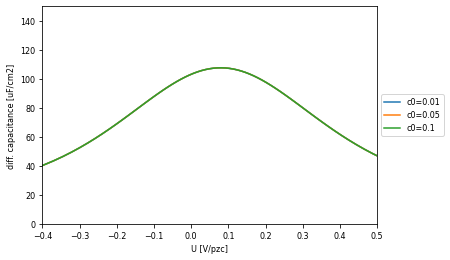

In [116]:
#c0list=[0.0001,0.0002, 0.0004,0.0006, 0.0011, 0.0021]
c0list=[0.01, 0.05, 0.1]#,0.0004, 0.0021]
C_H=18
kwargs=deepcopy(kwargs0)
waterAds=deepcopy(waterAds0)
waterAds['l_A']=2.0*const.angstrom
kwargs['cmax']=40000
kwargs['xRepulsiveAn']=6
kwargs['xRepulsiveCat']=6
kwargs['xAttractiveAn']=10
kwargs['xAttractiveCat']=10
kwargs['UpotCat']=attractive2
kwargs['UpotAn']=attractive2
kwargs['EAttractiveAn']=0.0
kwargs['EAttractiveCat']=0.0

fig1=plt.figure()
ax1=fig1.gca()
line_colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
nMult=1
for j,myc0 in enumerate(c0list):
    kwargs['c0An']=myc0
    kwargs['c0Cat']=myc0
    #qVAt,UCdiffAt=getCapacity('curve',show=-1,rangeMult=0.3,nMult=nMult,tol=1E-7, **kwargs)#1.8
    
    #sigma_list=qVAt[:,0]*const.e/(kwargs['A']*au2m**2)
    sigma_list=(np.arange(-0.6,0.8,0.02)+0.001)*const.e/(kwargs['A']*au2m**2)
    thetaA_list=[]
    DeltaPhiWater_list=[]
    OneOverCWater_list=[]
    DeltaPhiCH_list=[]
    CWaterNum_list=[]
    DeltaPhiWater_list_forCH=[]
    DeltaPhiCH_list_forCH=[]
    for sigmaVal in sigma_list:
        mysigma=lambda x: sigma(x, **waterAds, sigmaVal=sigmaVal)
        thetaA=fsolve(mysigma, 0.01)[0]
        thetaA_list.append(thetaA)
        DeltaPhiVal=DeltaPhiWater(thetaA, sigmaVal, **waterAds)
        DeltaPhiWater_list.append(DeltaPhiVal)
        OneOverCWater=get_OneOverCWater(thetaA, **waterAds)
        OneOverCWater_list.append(OneOverCWater)
        DeltaPhiCH_list.append(sigmaVal/C_H*1E2)
    for i in range(0,len(sigma_list)-1):
        CWaterNum_list.append((sigma_list[i+1]-sigma_list[i])/(DeltaPhiWater_list[i+1]-DeltaPhiWater_list[i]))
        DeltaPhiWater_list_forCH.append((DeltaPhiWater_list[i+1]+DeltaPhiWater_list[i])/2)
        DeltaPhiCH_list_forCH.append((DeltaPhiCH_list[i+1]+DeltaPhiCH_list[i])/2)
    OneOverCWater_list=np.array(OneOverCWater_list)
    CWaterNum_list=np.array(CWaterNum_list)
    DeltaPhiCH_list_forCH=np.array(DeltaPhiCH_list_forCH)
    DeltaPhiWater_list_forCH=np.array(DeltaPhiWater_list_forCH)
    
    #plt.figure()
    #plt.plot(DeltaPhiWater_list, 1/OneOverCWater_list)
    #plt.plot(DeltaPhiWater_list_forCH, CWaterNum_list)
        
    #ax1.plot(UCdiffAt[:,0], UCdiffAt[:,1], label='c0={}'.format(myc0), color=line_colors[j])
    ax1.plot(DeltaPhiWater_list_forCH+DeltaPhiCH_list_forCH, 1/(1/C_H+1/CWaterNum_list*1E-2), color=line_colors[j], label='c0={}'.format(myc0))
    
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_xlabel("U [V/pzc]")
ax1.set_ylabel("diff. capacitance [uF/cm2]")
ax1.set_xlim(-0.4,0.5)
ax1.set_ylim(0,150)

ion attraction (cations larger than anions) and water adsorption (with modified parameters for water adsorption)

C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow e

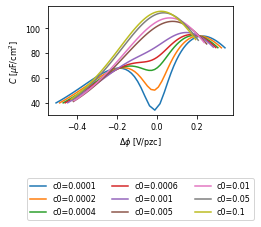

In [117]:
#c0list=[0.0001,0.0002, 0.0004,0.0006, 0.0011, 0.0021]
c0list=[0.0001, 0.0002, 0.0004,0.0006, 0.001, 0.005, 0.01, 0.05, 0.1]#,0.0004, 0.0021]
kwargs=deepcopy(kwargs0)
waterAds=deepcopy(waterAds0)
waterAds['l_A']=2.0*const.angstrom
kwargs['cmax']=40000
kwargs['xRepulsiveAn']=6
kwargs['xRepulsiveCat']=8
kwargs['xAttractiveAn']=10
kwargs['xAttractiveCat']=10
kwargs['UpotCat']=attractive2
kwargs['UpotAn']=attractive2
kwargs['EAttractiveAn']=0.22
kwargs['EAttractiveCat']=0.22

fig1=plt.figure(figsize=(3.33,2))
ax1=fig1.gca()
line_colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
nMult=1
for j,myc0 in enumerate(c0list):
    kwargs['c0An']=myc0
    kwargs['c0Cat']=myc0
    qVAt,UCdiffAt=getCapacity('curve',show=-1,rangeMult=0.3,nMult=nMult,tol=1E-7, **kwargs)#1.8
    
    sigma_list=qVAt[:,0]*const.e/(kwargs['A']*au2m**2)
    thetaA_list=[]
    DeltaPhiWater_list=[]
    OneOverCWater_list=[]
    CWaterNum_list=[]
    DeltaPhiWater_list_forCH=[]
    for sigmaVal in sigma_list:
        mysigma=lambda x: sigma(x, **waterAds, sigmaVal=sigmaVal)
        thetaA=fsolve(mysigma, 0.01)[0]
        thetaA_list.append(thetaA)
        DeltaPhiVal=DeltaPhiWater(thetaA, sigmaVal, **waterAds)
        DeltaPhiWater_list.append(DeltaPhiVal)
        OneOverCWater=get_OneOverCWater(thetaA, **waterAds)
        OneOverCWater_list.append(OneOverCWater)
    for i in range(0,len(sigma_list)-1):
        CWaterNum_list.append((sigma_list[i+1]-sigma_list[i])/(DeltaPhiWater_list[i+1]-DeltaPhiWater_list[i]))
        DeltaPhiWater_list_forCH.append((DeltaPhiWater_list[i+1]+DeltaPhiWater_list[i])/2)
    OneOverCWater_list=np.array(OneOverCWater_list)
    CWaterNum_list=np.array(CWaterNum_list)
    
    #plt.figure()
    #plt.plot(DeltaPhiWater_list, 1/OneOverCWater_list)
    #plt.plot(DeltaPhiWater_list_forCH, CWaterNum_list)
        
    #ax1.plot(UCdiffAt[:,0], UCdiffAt[:,1], label='c0={}'.format(myc0), color=line_colors[j])
    ax1.plot(UCdiffAt[:,0]+DeltaPhiWater_list_forCH, 1/(1/UCdiffAt[:,1]+1/CWaterNum_list*1E-2), color=line_colors[j], label='c0={}'.format(myc0))
    
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0),ncol=3)
#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_xlabel("$\Delta \phi$ [V/pzc]")
ax1.set_ylabel("$C$ [$\mu$F/cm$^2$]")
fig1.savefig('cationsLargerThanAnions.svg', format='svg', dpi=300)

ion attraction (cations smaller than anions) and water adsorption (with modified parameters for water adsorption)

C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\doblhoffdierk\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow e

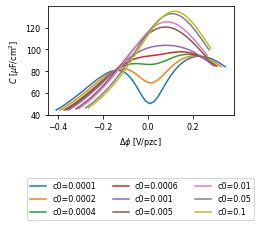

In [118]:
#c0list=[0.0001,0.0002, 0.0004,0.0006, 0.0011, 0.0021]
c0list=[0.0001, 0.0002, 0.0004,0.0006, 0.001, 0.005, 0.01, 0.05, 0.1]#,0.0004, 0.0021]
kwargs=deepcopy(kwargs0)
waterAds=deepcopy(waterAds0)
waterAds['l_A']=2.0*const.angstrom
kwargs['cmax']=40000
kwargs['xRepulsiveAn']=6
kwargs['xRepulsiveCat']=4
kwargs['xAttractiveAn']=10
kwargs['xAttractiveCat']=10
kwargs['UpotCat']=attractive2
kwargs['UpotAn']=attractive2
kwargs['EAttractiveAn']=0.22
kwargs['EAttractiveCat']=0.22

fig1=plt.figure(figsize=(3.33,2))
ax1=fig1.gca()
line_colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
nMult=1
for j,myc0 in enumerate(c0list):
    kwargs['c0An']=myc0
    kwargs['c0Cat']=myc0
    qVAt,UCdiffAt=getCapacity('curve',show=-1,rangeMult=0.3,nMult=nMult,tol=1E-7, **kwargs)#1.8
    
    sigma_list=qVAt[:,0]*const.e/(kwargs['A']*au2m**2)
    thetaA_list=[]
    DeltaPhiWater_list=[]
    OneOverCWater_list=[]
    CWaterNum_list=[]
    DeltaPhiWater_list_forCH=[]
    for sigmaVal in sigma_list:
        mysigma=lambda x: sigma(x, **waterAds, sigmaVal=sigmaVal)
        thetaA=fsolve(mysigma, 0.01)[0]
        thetaA_list.append(thetaA)
        DeltaPhiVal=DeltaPhiWater(thetaA, sigmaVal, **waterAds)
        DeltaPhiWater_list.append(DeltaPhiVal)
        OneOverCWater=get_OneOverCWater(thetaA, **waterAds)
        OneOverCWater_list.append(OneOverCWater)
    for i in range(0,len(sigma_list)-1):
        CWaterNum_list.append((sigma_list[i+1]-sigma_list[i])/(DeltaPhiWater_list[i+1]-DeltaPhiWater_list[i]))
        DeltaPhiWater_list_forCH.append((DeltaPhiWater_list[i+1]+DeltaPhiWater_list[i])/2)
    OneOverCWater_list=np.array(OneOverCWater_list)
    CWaterNum_list=np.array(CWaterNum_list)
    
    #plt.figure()
    #plt.plot(DeltaPhiWater_list, 1/OneOverCWater_list)
    #plt.plot(DeltaPhiWater_list_forCH, CWaterNum_list)
        
    #ax1.plot(UCdiffAt[:,0], UCdiffAt[:,1], label='c0={}'.format(myc0), color=line_colors[j])
    ax1.plot(UCdiffAt[:,0]+DeltaPhiWater_list_forCH, 1/(1/UCdiffAt[:,1]+1/CWaterNum_list*1E-2), color=line_colors[j], label='c0={}'.format(myc0))
    
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0),ncol=3)
#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_xlabel("$\Delta \phi$ [V/pzc]")
ax1.set_ylabel("$C$ [$\mu$F/cm$^2$]")
fig1.savefig('cationsSmallerThanAnions.svg', format='svg', dpi=300)